In [44]:
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn import tree
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score

import pandas as pd
from pyspark.sql import SparkSession
import pyspark.pandas as ps

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
import dtreeviz # remember to load the package

In [45]:
!python test_for_cls.py -v

test_par (__main__.full_test.test_par) ... ERROR

ERROR: test_par (__main__.full_test.test_par)
----------------------------------------------------------------------
Traceback (most recent call last):
  File "c:\Users\nikgo\Documents\NSU\Theory_of_stat_decisions\Theory_of_stat_decisions\lab03\test_for_cls.py", line 25, in test_par
    self.assertNotEqual(gender_parce(1, df), df_t)
  File "c:\Users\nikgo\AppData\Local\Programs\Python\Python311\Lib\unittest\case.py", line 879, in assertNotEqual
    if not first != second:
           ^^^^^^^^^^^^^^^
  File "c:\Users\nikgo\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\generic.py", line 1466, in __nonzero__
    raise ValueError(
ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

----------------------------------------------------------------------
Ran 1 test in 0.004s

FAILED (errors=1)


In [46]:
df = pd.read_csv('./data/survey.csv')
df = df.drop(columns=['state', 'Country', 'Timestamp', 'comments', 'no_employees'])

uniq = df['Gender'].unique()
dict_fot_col = {}
for var in uniq:
    if var[0] == 'm' or var[0] == 'M':
        dict_fot_col[var] = 'M'
    else:
        dict_fot_col[var] = 'F'

df['Gender'] = df['Gender'].map(dict_fot_col)
df = df.dropna()

#df['Gender'] = gender_parce(df.shape[0], df['Gender'])
print(df)

      Age Gender self_employed family_history treatment work_interfere   
18     46      M           Yes            Yes        No      Sometimes  \
20     29      M            No            Yes       Yes      Sometimes   
21     31      M           Yes             No        No          Never   
22     46      M            No             No       Yes          Often   
23     41      M            No             No       Yes          Never   
...   ...    ...           ...            ...       ...            ...   
1252   29      M            No            Yes       Yes      Sometimes   
1253   36      M            No            Yes        No         Rarely   
1255   32      M            No            Yes       Yes          Often   
1256   34      M            No            Yes       Yes      Sometimes   
1258   25      M            No            Yes       Yes      Sometimes   

     remote_work tech_company    benefits care_options  ...   anonymity   
18           Yes          Yes       

In [47]:
colmn = df.columns
print(colmn)

Index(['Age', 'Gender', 'self_employed', 'family_history', 'treatment',
       'work_interfere', 'remote_work', 'tech_company', 'benefits',
       'care_options', 'wellness_program', 'seek_help', 'anonymity', 'leave',
       'mental_health_consequence', 'phys_health_consequence', 'coworkers',
       'supervisor', 'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence'],
      dtype='object')


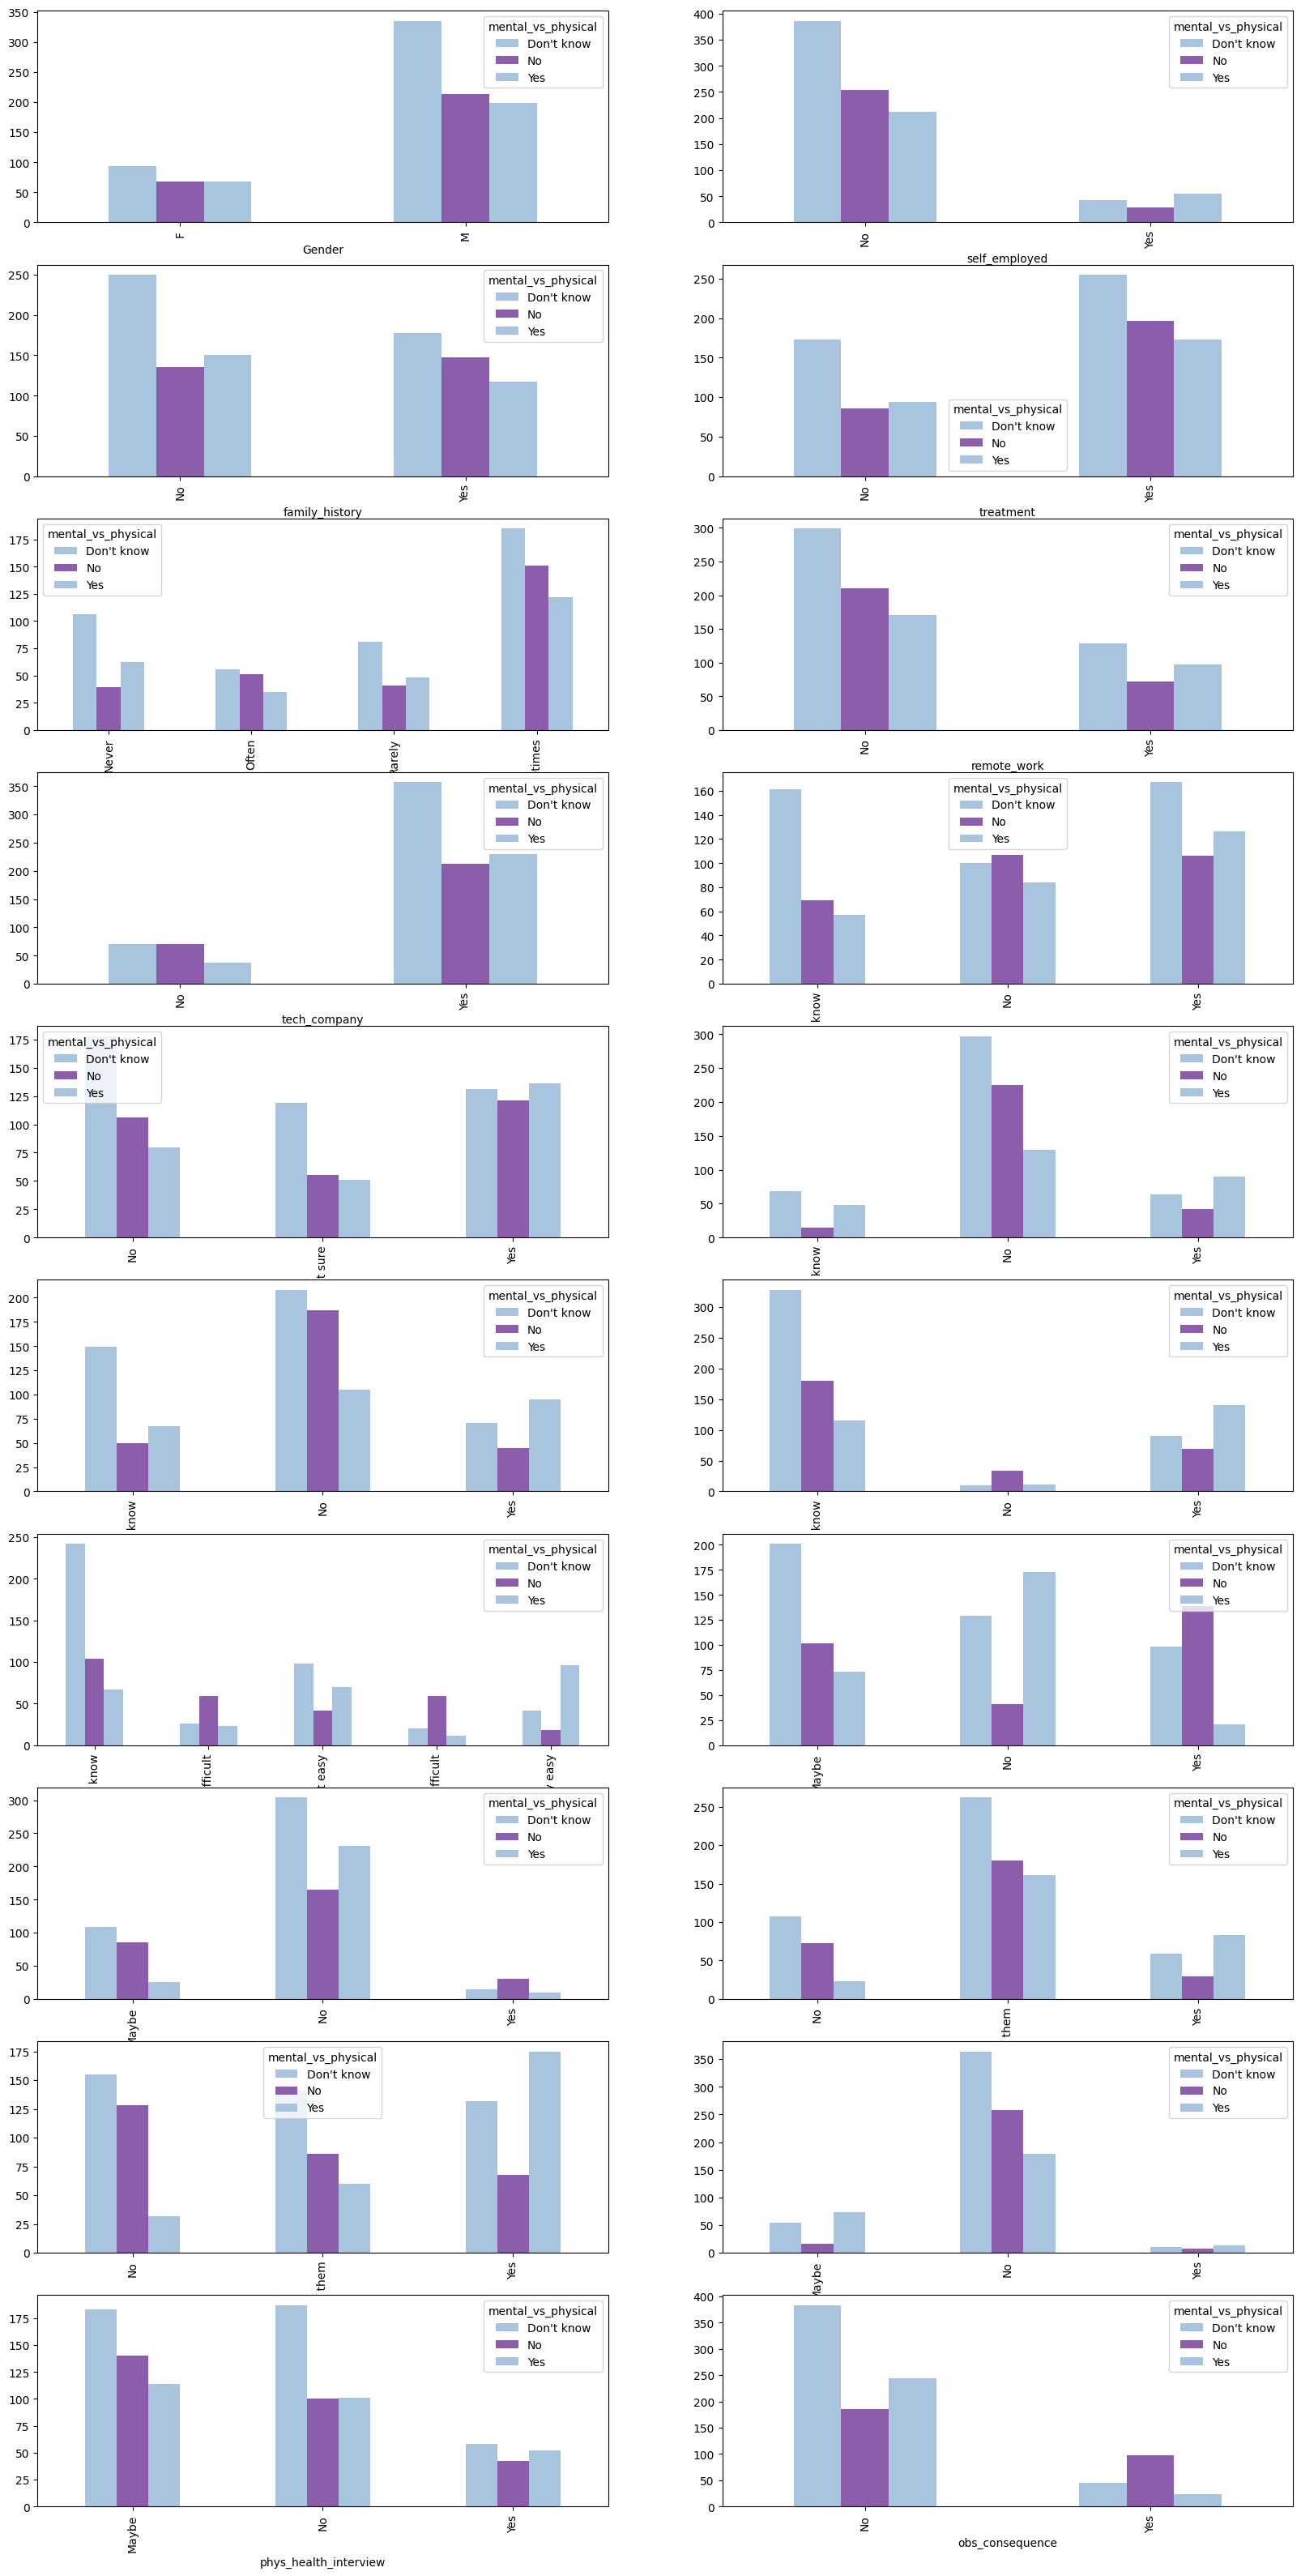

In [48]:
df_for_img = pd.DataFrame()
columns = list(df.drop(['mental_vs_physical', 'Age'], axis = 1))
fig, axes = plt.subplots(10, 2, figsize=(20, 40))
for i, col in enumerate(columns):
    df_f = df.groupby(col)['mental_vs_physical'].value_counts().unstack()
    df_f.plot.bar(ax=axes[i//2, i%2], color = sns.color_palette("BuPu", 2))
    df_f = df_f.rename(index=lambda x: df_f.index.name + '_' + x )
    df_for_img =  pd.concat([df_for_img, df_f])
plt.show()

<h4>My target - "famili_history"</h4>
<p>I would like to predict is thare another members of family, how got mental illnes<p>
<p>Let's see, how does data here look</p>
<p> 1 - Yes, 0 - No</p>

In [49]:
# Let's Encod data
encoder = LabelEncoder()
colmn = df.columns
for index, name in enumerate(colmn):
    df[name] = encoder.fit_transform(df[name].values)

In [50]:
df.corr()

,Age,Gender,self_employed,family_history,treatment,work_interfere,remote_work,tech_company,benefits,care_options,...,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
Age,1.000000,0.111911,0.056169,-0.009403,0.052979,-0.021069,0.140021,-0.026845,0.157036,0.124909,...,0.038472,-0.013951,0.012334,-0.073413,-0.006991,0.010155,0.080297,-0.004937,-0.019093,0.071090
Gender,0.111911,1.000000,0.016629,-0.142716,-0.189823,-0.098208,0.009701,0.083117,-0.121523,-0.127768,...,-0.040153,0.047353,0.001037,0.044620,0.044971,0.069371,-0.078351,-0.032912,-0.037205,-0.105286
self_employed,0.056169,0.016629,1.000000,-0.021860,-0.018092,-0.013891,0.338583,0.077589,-0.082432,0.024212,...,0.075766,0.162032,0.027306,0.031012,0.069901,0.037743,-0.012525,0.006233,0.124467,0.080886
family_history,-0.009403,-0.142716,-0.021860,1.000000,0.328335,0.234411,0.018684,-0.055789,0.102393,0.080060,...,0.054112,-0.012818,0.013901,-0.001438,-0.008398,0.004553,0.048658,0.085552,0.029429,0.078783
treatment,0.052979,-0.189823,-0.018092,0.328335,1.000000,0.413105,0.021614,-0.045888,0.203983,0.203285,...,0.162318,0.046715,-0.001698,-0.019477,0.087725,0.004267,0.107058,0.100756,0.053653,0.111560
work_interfere,-0.021069,-0.098208,-0.013891,0.234411,0.413105,1.000000,0.023787,0.013525,0.052437,0.085642,...,0.068279,0.021952,0.026841,-0.048033,0.001087,-0.078030,0.097220,0.008752,0.030658,0.071544
remote_work,0.140021,0.009701,0.338583,0.018684,0.021614,0.023787,1.000000,0.134149,-0.064710,0.004258,...,0.002751,0.105960,0.030681,-0.016168,0.092690,0.057555,-0.026320,-0.015666,0.045978,-0.031612
tech_company,-0.026845,0.083117,0.077589,-0.055789,-0.045888,0.013525,0.134149,1.000000,-0.033845,-0.013992,...,-0.049974,0.044467,-0.031623,0.067941,0.069398,0.031421,-0.022096,-0.014461,0.014962,-0.070342
benefits,0.157036,-0.121523,-0.082432,0.102393,0.203983,0.052437,-0.064710,-0.033845,1.000000,0.464348,...,0.329791,0.037924,-0.040986,-0.024626,0.011313,0.039902,0.014602,0.020001,0.121430,0.056232
care_options,0.124909,-0.127768,0.024212,0.080060,0.203285,0.085642,0.004258,-0.013992,0.464348,1.000000,...,0.361638,0.133529,0.004248,0.046348,0.044932,0.096816,0.022137,0.045417,0.150911,0.077715


<Axes: >

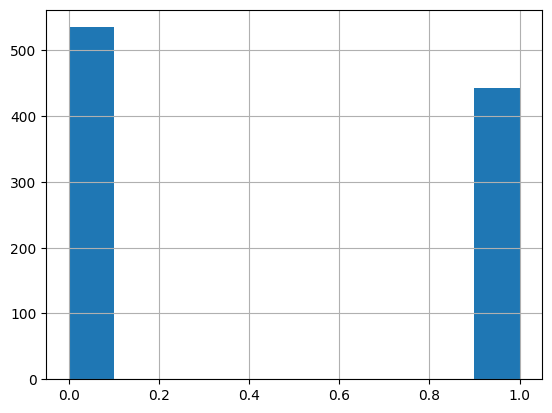

In [51]:
df['family_history'].hist()

<h4>Deciosion tree</h4>

In [52]:
# there are literli function plot_tree to visualize that

X = df.drop(columns='family_history')
y = pd.DataFrame(df['family_history'])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

# Fit the classifier with default hyper-parameters
clf = DecisionTreeClassifier()
model = clf.fit(X, y)

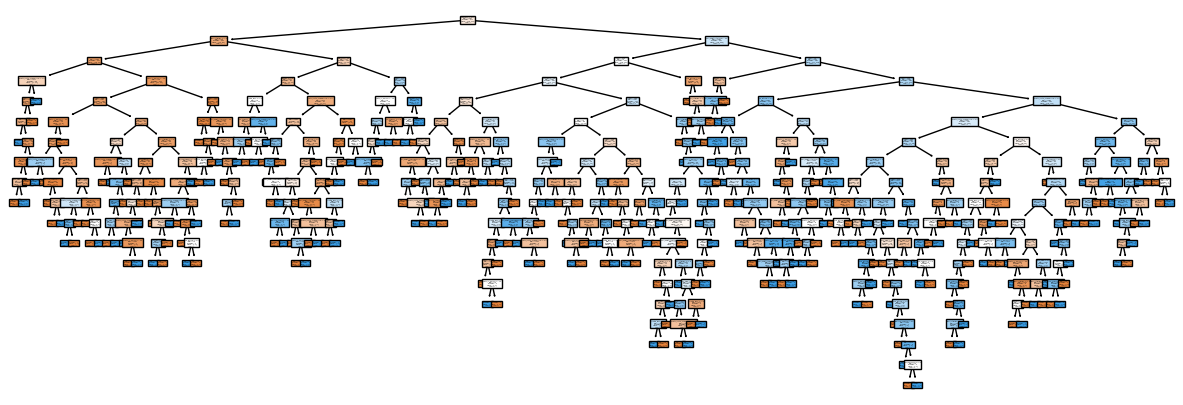

In [53]:
fig = plt.figure(figsize=(15, 5))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names='family_history',
                   filled=True)

In [54]:
pred_rt = model.predict(X_test)


In [55]:
accuracy_score(y_test, pred_rt)

1.0

Blyat((((

<h3>Boosting</h3>

In [56]:
from xgboost import XGBClassifier

bost_model = XGBClassifier()

bost_model.fit(X_train, y_train)

pred = bost_model.predict(X_test)